# Usage
This series of tutorial notebooks is intended to be a collection of functions and processes to be run on typical clickstream datasets.

# Contents:
You can safely skip certain chapters of this tutorial. If something doesn't make sense, look to the cells above. If it still doesn't make sense, shoot me an angry (but descriptive) email- that usually makes me update this with clarifications.

* List of lists data [Tutorial 1]
    * Handling the data
    * Most frequented pages
    * Most frequent paths
* Structured, tabulated data [Tutorial 2]
* Focus on Video data [Tutorial 3] (can be extended to use cases in any similar form of online content)

## Data Format(s)

### List of content accessed
Some datasets may be represented as a collection of clickstream pathways. We can still salvage meaningful information from these datasets. Here, each individual row corresponds to a separate session, and each element in the row represents a content ID. The order in which these content IDs are listed is typically the order in which they were accessed. This information may or may not be linked to other attributes like timestamps, user IDs, or other attributes like the richer dataset shown above:

```
10307 10311 12487
12559
12695 12703 18715
10311 12387 12515 12691 12695 12699 12703 12823 12831 12847 18595 18679 18751
...
```

### Structured data
This notebook largely assumes that the data is organized roughly as below:

|      date_time      | user_id | content_id |     attr1    |           attr2           |   attr3  | ... |
|:-------------------:|:-------:|:----------:|:------------:|:-------------------------:|:--------:|:---:|
| 2011-01-01 00:00:00 |  user_x |  webpage_i |  google.com  |    "slick amazon deals"   | Nebraska | ... |
| 2011-01-01 00:10:00 |  user_y |  webpage_i | facebook.com | "reddit photoshopbattles" | New York | ... |


If your click data is not in this format, you may consider pre-processing it into to this format. If you have a specific proprietary format that you would like to analyze using this code, feel free to contact me.

In [1]:
#boilerplate imports
import pandas as pd
import numpy as np
from collections import Counter
import pprint

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set(color_codes=True)

C:\Anaconda\lib\site-packages\matplotlib\__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


### Let's dive right in!
The simplest form of data you'll encounter is the list of clicks. Here's an example of how to get started with the simplest use-case.

In [3]:
#getting the data from a URL [can be made easier if you have a local copy]
#data obtained from Philippe Fournier Viger's SPMF page. This is a KDD Cup 2000 dataset
import urllib2
target_url = "http://www.philippe-fournier-viger.com/spmf/datasets/BMS1_itemset_mining.txt"
list_of_clicks = urllib2.urlopen(target_url).readlines()

In [4]:
#see what the data looks like
for _line in list_of_clicks[:5]:
    print " -> ".join(_line.split())

10307 -> 10311 -> 12487
12559
12695 -> 12703 -> 18715
10311 -> 12387 -> 12515 -> 12691 -> 12695 -> 12699 -> 12703 -> 12823 -> 12831 -> 12847 -> 18595 -> 18679 -> 18751
10291 -> 12523 -> 12531 -> 12535 -> 12883


In [5]:
#each line is a string, let's make it into a list exactly like we did when viewing it
for _line_num in range(len(list_of_clicks)):
    list_of_clicks[_line_num] = (list_of_clicks[_line_num]).split()

In [6]:
#let's find the most common pages accessed in the dataset
#flatten the list of lists...
import itertools
flat_list_of_clicks = list(itertools.chain(*list_of_clicks))

In [7]:
most_common_cntr = Counter(flat_list_of_clicks).most_common(20)

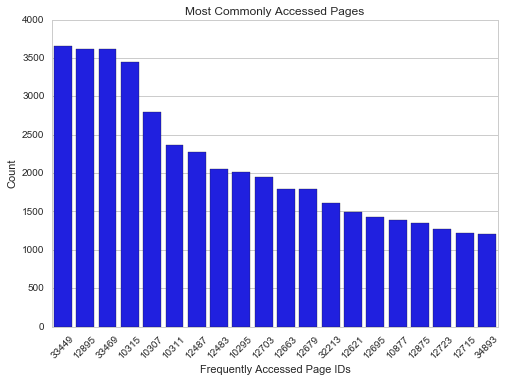

In [8]:
sns.set_style("whitegrid")
ax = sns.barplot(x=[i[0] for i in most_common_cntr],y = [i[1] for i in most_common_cntr], color = 'blue')
ax.set(xlabel = "Frequently Accessed Page IDs", ylabel = "Count", title = "Most Commonly Accessed Pages")
for item in ax.get_xticklabels():
    item.set_rotation(45)

plt.show()

Let's see what the overall distribution looks like:

A large number of these pages were accessed a few times; unsurprisingly enough, very few were accessed very frequently

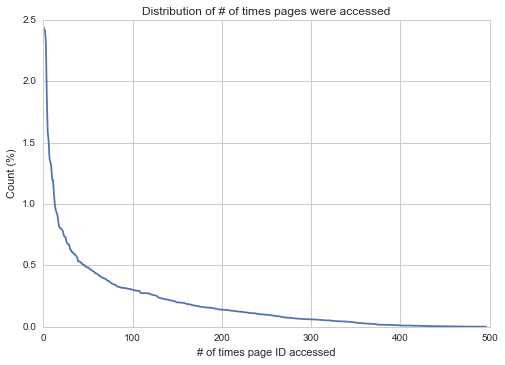

In [9]:
sns.set_style("whitegrid")
_sum_total = sum(Counter(flat_list_of_clicks).values()) #total number of accesses
_plot_this = sorted([100*float(i)/_sum_total for i in Counter(flat_list_of_clicks).values()],reverse=True) 
# (times this content was accessed) / (# of times any content was accessed) 
plt.plot(_plot_this)
plt.title("Distribution of # of times pages were accessed")
plt.xlabel("# of times page ID accessed")
plt.ylabel("Count (%)")
plt.show()

## How do we get infer association rules from this?
[TL/DR] : Run the cell below and skip to the code after it.

Feel free to look at the finer details of the apriori code if you really want to know what's going on under the hood

In [10]:
# (c) 2014 Everaldo Aguiar & Reid Johnson
#
# Modified from:
# Marcel Caraciolo (https://gist.github.com/marcelcaraciolo/1423287)
#
# Functions to compute and extract association rules from a given frequent 
# itemset generated by the Apriori algorithm.

def apriori(dataset, min_support=0.5, verbose=False):
    """Implements the Apriori algorithm.

    The Apriori algorithm will iteratively generate new candidate 
    k-itemsets using the frequent (k-1)-itemsets found in the previous 
    iteration.

    Parameters
    ----------
    dataset : list
        The dataset (a list of transactions) from which to generate 
        candidate itemsets.

    min_support : float
        The minimum support threshold. Defaults to 0.5.

    Returns
    -------
    F : list
        The list of frequent itemsets.

    support_data : dict
        The support data for all candidate itemsets.

    References
    ----------
    .. [1] R. Agrawal, R. Srikant, "Fast Algorithms for Mining Association 
           Rules", 1994.

    """
    C1 = create_candidates(dataset)
    D = map(set, dataset)
    F1, support_data = support_prune(D, C1, min_support, verbose=False) # prune candidate 1-itemsets
    F = [F1] # list of frequent itemsets; initialized to frequent 1-itemsets
    k = 2 # the itemset cardinality
    while (len(F[k - 2]) > 0):
        Ck = apriori_gen(F[k-2], k) # generate candidate itemsets
        Fk, supK = support_prune(D, Ck, min_support) # prune candidate itemsets
        support_data.update(supK) # update the support counts to reflect pruning
        F.append(Fk) # add the pruned candidate itemsets to the list of frequent itemsets
        k += 1

    if verbose:
        # Print a list of all the frequent itemsets.
        for kset in F:
            for item in kset:
                print("" \
                    + "{" \
                    + "".join(str(i) + ", " for i in iter(item)).rstrip(', ') \
                    + "}" \
                    + ":  sup = " + str(round(support_data[item], 3)))

    return F, support_data

def create_candidates(dataset, verbose=False):
    """Creates a list of candidate 1-itemsets from a list of transactions.

    Parameters
    ----------
    dataset : list
        The dataset (a list of transactions) from which to generate candidate 
        itemsets.

    Returns
    -------
    The list of candidate itemsets (c1) passed as a frozenset (a set that is 
    immutable and hashable).
    """
    c1 = [] # list of all items in the database of transactions
    for transaction in dataset:
        for item in transaction:
            if not [item] in c1:
                c1.append([item])
    c1.sort()

    if verbose:
        # Print a list of all the candidate items.
        print("" \
            + "{" \
            + "".join(str(i[0]) + ", " for i in iter(c1)).rstrip(', ') \
            + "}")

    # Map c1 to a frozenset because it will be the key of a dictionary.
    return map(frozenset, c1)

def support_prune(dataset, candidates, min_support, verbose=False):
    """Returns all candidate itemsets that meet a minimum support threshold.

    By the apriori principle, if an itemset is frequent, then all of its 
    subsets must also be frequent. As a result, we can perform support-based 
    pruning to systematically control the exponential growth of candidate 
    itemsets. Thus, itemsets that do not meet the minimum support level are 
    pruned from the input list of itemsets (dataset).

    Parameters
    ----------
    dataset : list
        The dataset (a list of transactions) from which to generate candidate 
        itemsets.

    candidates : frozenset
        The list of candidate itemsets.

    min_support : float
        The minimum support threshold.

    Returns
    -------
    retlist : list
        The list of frequent itemsets.

    support_data : dict
        The support data for all candidate itemsets.
    """
    sscnt = {} # set for support counts
    for tid in dataset:
        for can in candidates:
            if can.issubset(tid):
                sscnt.setdefault(can, 0)
                sscnt[can] += 1

    num_items = float(len(dataset)) # total number of transactions in the dataset
    retlist = [] # array for unpruned itemsets
    support_data = {} # set for support data for corresponding itemsets
    for key in sscnt:
        # Calculate the support of itemset key.
        support = sscnt[key] / num_items
        if support >= min_support:
            retlist.insert(0, key)
        support_data[key] = support

    # Print a list of the pruned itemsets.
    if verbose:
        for kset in retlist:
            for item in kset:
                print("{" + str(item) + "}")
        print("")
        for key in sscnt:
            print("" \
                + "{" \
                + "".join([str(i) + ", " for i in iter(key)]).rstrip(', ') \
                + "}" \
                + ":  sup = " + str(support_data[key]))

    return retlist, support_data

def apriori_gen(freq_sets, k):
    """Generates candidate itemsets (via the F_k-1 x F_k-1 method).

    This operation generates new candidate k-itemsets based on the frequent 
    (k-1)-itemsets found in the previous iteration. The candidate generation 
    procedure merges a pair of frequent (k-1)-itemsets only if their first k-2 
    items are identical.

    Parameters
    ----------
    freq_sets : list
        The list of frequent (k-1)-itemsets.

    k : integer
        The cardinality of the current itemsets being evaluated.

    Returns
    -------
    retlist : list
        The list of merged frequent itemsets.
    """
    retList = [] # list of merged frequent itemsets
    lenLk = len(freq_sets) # number of frequent itemsets
    for i in range(lenLk):
        for j in range(i+1, lenLk):
            a=list(freq_sets[i])
            b=list(freq_sets[j])
            a.sort()
            b.sort()
            F1 = a[:k-2] # first k-2 items of freq_sets[i]
            F2 = b[:k-2] # first k-2 items of freq_sets[j]

            if F1 == F2: # if the first k-2 items are identical
                # Merge the frequent itemsets.
                retList.append(freq_sets[i] | freq_sets[j])

    return retList

def rules_from_conseq(freq_set, H, support_data, rules, min_confidence=0.5, verbose=False):
    """Generates a set of candidate rules.

    Parameters
    ----------
    freq_set : frozenset
        The complete list of frequent itemsets.

    H : list
        A list of frequent itemsets (of a particular length).

    support_data : dict
        The support data for all candidate itemsets.

    rules : list
        A potentially incomplete set of candidate rules above the minimum 
        confidence threshold.

    min_confidence : float
        The minimum confidence threshold. Defaults to 0.5.
    """
    m = len(H[0])
    if m == 1:
        Hmp1 = calc_confidence(freq_set, H, support_data, rules, min_confidence, verbose)
    if (len(freq_set) > (m+1)):
        Hmp1 = apriori_gen(H, m+1) # generate candidate itemsets
        Hmp1 = calc_confidence(freq_set, Hmp1, support_data, rules, min_confidence, verbose)
        if len(Hmp1) > 1:
            # If there are candidate rules above the minimum confidence 
            # threshold, recurse on the list of these candidate rules.
            rules_from_conseq(freq_set, Hmp1, support_data, rules, min_confidence, verbose)

def calc_confidence(freq_set, H, support_data, rules, min_confidence=0.5, verbose=False):
    """Evaluates the generated rules.

    One measurement for quantifying the goodness of association rules is 
    confidence. The confidence for a rule 'P implies H' (P -> H) is defined as 
    the support for P and H divided by the support for P 
    (support (P|H) / support(P)), where the | symbol denotes the set union 
    (thus P|H means all the items in set P or in set H).

    To calculate the confidence, we iterate through the frequent itemsets and 
    associated support data. For each frequent itemset, we divide the support 
    of the itemset by the support of the antecedent (left-hand-side of the 
    rule).

    Parameters
    ----------
    freq_set : frozenset
        The complete list of frequent itemsets.

    H : list
        A list of frequent itemsets (of a particular length).

    min_support : float
        The minimum support threshold.

    rules : list
        A potentially incomplete set of candidate rules above the minimum 
        confidence threshold.

    min_confidence : float
        The minimum confidence threshold. Defaults to 0.5.

    Returns
    -------
    pruned_H : list
        The list of candidate rules above the minimum confidence threshold.
    """
    pruned_H = [] # list of candidate rules above the minimum confidence threshold
    for conseq in H: # iterate over the frequent itemsets
        conf = support_data[freq_set] / support_data[freq_set - conseq]
        if conf >= min_confidence:
            rules.append((freq_set - conseq, conseq, conf))
            pruned_H.append(conseq)

            if verbose:
                print("" \
                    + "{" \
                    + "".join([str(i) + ", " for i in iter(freq_set-conseq)]).rstrip(', ') \
                    + "}" \
                    + " ---> " \
                    + "{" \
                    + "".join([str(i) + ", " for i in iter(conseq)]).rstrip(', ') \
                    + "}" \
                    + ":  conf = " + str(round(conf, 3)) \
                    + ", sup = " + str(round(support_data[freq_set], 3)))

    return pruned_H

def generate_rules(F, support_data, min_confidence=0.5, verbose=True):
    """Generates a set of candidate rules from a list of frequent itemsets.

    For each frequent itemset, we calculate the confidence of using a
    particular item as the rule consequent (right-hand-side of the rule). By 
    testing and merging the remaining rules, we recursively create a list of 
    pruned rules.

    Parameters
    ----------
    F : list
        A list of frequent itemsets.

    support_data : dict
        The corresponding support data for the frequent itemsets (L).

    min_confidence : float
        The minimum confidence threshold. Defaults to 0.5.

    Returns
    -------
    rules : list
        The list of candidate rules above the minimum confidence threshold.
    """
    rules = []
    for i in range(1, len(F)):
        for freq_set in F[i]:
            H1 = [frozenset([itemset]) for itemset in freq_set]
            if (i > 1):
                rules_from_conseq(freq_set, H1, support_data, rules, min_confidence, verbose)
            else:
                calc_confidence(freq_set, H1, support_data, rules, min_confidence, verbose)

    return rules

## Parameter Estimation

We don't know what the best support and confidence values are for this unknown dataset. We experiment around with a bunch of values and pick a nice knee-point.

In [19]:
freq_item_len = []
freq_itemset_len = []
for minsup in [2**i for i in range(-7,-1)]:
    F, support_data = apriori(list_of_clicks, min_support=minsup, verbose=False)
    freq_item_len.append(len(F))
    freq_itemset_len.append(len(support_data))
    print "Minimum support: ", minsup, "\t#items:", len(F), "\titemset length:", len(support_data)

Minimum support:  0.0078125 	#items: 3 	itemset length: 4883
Minimum support:  0.015625 	#items: 3 	itemset length: 993
Minimum support:  0.03125 	#items: 2 	itemset length: 542
Minimum support:  0.0625 	#items: 1 	itemset length: 497
Minimum support:  0.125 	#items: 1 	itemset length: 497
Minimum support:  0.25 	#items: 1 	itemset length: 497


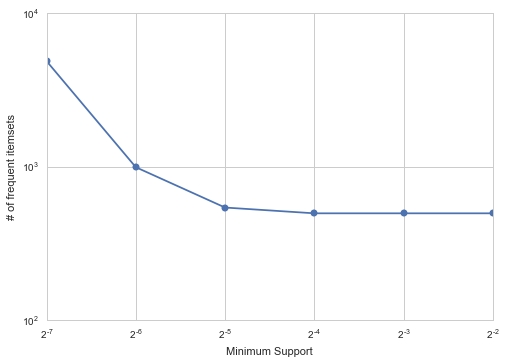

In [23]:
plt.loglog([2**i for i in range(-7,-1)],freq_itemset_len, basex = 2, basey = 10, marker='o')
plt.xlabel("Minimum Support")
plt.ylabel("# of frequent itemsets")
plt.show()

based on this plot, let's use $2^{-7}$, i.e. 0.78125% as the minimum support. 

Ideally, you would want to use the knee point, but I'm trying to make this a rudimentary example.

In [13]:
F, support_data = apriori(list_of_clicks, min_support=2**(-7), verbose=True)

{20807}:  sup = 0.008
{12627}:  sup = 0.013
{12679}:  sup = 0.03
{12807}:  sup = 0.01
{12355}:  sup = 0.018
{12847}:  sup = 0.008
{10331}:  sup = 0.012
{33429}:  sup = 0.01
{12747}:  sup = 0.009
{47957}:  sup = 0.011
{12575}:  sup = 0.008
{12463}:  sup = 0.013
{34905}:  sup = 0.012
{12467}:  sup = 0.008
{12603}:  sup = 0.011
{12547}:  sup = 0.008
{12567}:  sup = 0.015
{12551}:  sup = 0.009
{12695}:  sup = 0.024
{33433}:  sup = 0.015
{12827}:  sup = 0.017
{33449}:  sup = 0.061
{47953}:  sup = 0.009
{18691}:  sup = 0.008
{12703}:  sup = 0.033
{12835}:  sup = 0.009
{18787}:  sup = 0.012
{12683}:  sup = 0.013
{32213}:  sup = 0.027
{12411}:  sup = 0.013
{12571}:  sup = 0.011
{12663}:  sup = 0.03
{12883}:  sup = 0.008
{12815}:  sup = 0.012
{12779}:  sup = 0.013
{12823}:  sup = 0.01
{12487}:  sup = 0.038
{12667}:  sup = 0.01
{12783}:  sup = 0.016
{12555}:  sup = 0.008
{10861}:  sup = 0.008
{12299}:  sup = 0.009
{12715}:  sup = 0.02
{12723}:  sup = 0.021
{10299}:  sup = 0.012
{48675}:  sup = 0

# Generating rules for browsing patterns
The whole idea of doing this was to find out if we could identify patterns in browsing. In this section of the code, we use frequent itemset mining, which is agnostic of the actual path taken. 


### How to read these rules:
Here we get rules which resemble the output below: 
```
{A, B, C} ---> {X} : conf = something, sup = something_else 
```
*Browsing A, B and C is related to **also**  browsing X*, with the displayed confidence and support.

We will deal with the path-aware approach that in the section on **sequence mining**.

In [15]:
H = generate_rules(F, support_data, min_confidence=0.25, verbose=True)

{12487} ---> {12703}:  conf = 0.278, sup = 0.011
{12703} ---> {12487}:  conf = 0.324, sup = 0.011
{12703} ---> {12695}:  conf = 0.316, sup = 0.01
{12695} ---> {12703}:  conf = 0.432, sup = 0.01
{12827} ---> {12895}:  conf = 0.58, sup = 0.01
{10311} ---> {10295}:  conf = 0.311, sup = 0.012
{10295} ---> {10311}:  conf = 0.367, sup = 0.012
{12703} ---> {10311}:  conf = 0.296, sup = 0.01
{33469} ---> {33449}:  conf = 0.333, sup = 0.02
{33449} ---> {33469}:  conf = 0.329, sup = 0.02
{32213} ---> {12703}:  conf = 0.353, sup = 0.01
{12703} ---> {32213}:  conf = 0.293, sup = 0.01
{33433} ---> {33469}:  conf = 0.571, sup = 0.009
{12487} ---> {10311}:  conf = 0.271, sup = 0.01
{10311} ---> {12487}:  conf = 0.259, sup = 0.01
{10307} ---> {10295}:  conf = 0.327, sup = 0.015
{10295} ---> {10307}:  conf = 0.456, sup = 0.015
{12487} ---> {12483}:  conf = 0.387, sup = 0.015
{12483} ---> {12487}:  conf = 0.428, sup = 0.015
{12815} ---> {12895}:  conf = 0.784, sup = 0.009
{10311} ---> {10315}:  conf = 0

Increasing the value of minimum confidence increases the strictness of bounds we expect of the bounds. 
Naturally, relaxing this bound will result in less strict rules being displayed

In [16]:
H = generate_rules(F, support_data, min_confidence=0.5, verbose=True)

{12827} ---> {12895}:  conf = 0.58, sup = 0.01
{33433} ---> {33469}:  conf = 0.571, sup = 0.009
{12815} ---> {12895}:  conf = 0.784, sup = 0.009
